<a href="https://colab.research.google.com/github/arthursl12/MIR/blob/master/Lab10/lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-46ylgmrl
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-46ylgmrl
     |████████████████████████████████| 207 kB 12.1 MB/s 
     |████████████████████████████████| 126 kB 56.4 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
  Created wheel for musica-dcc-ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3414 sha256=3072676af80615b8ba3652cb422cfab26b03e9f786c2f245751ad43a7666b79f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mnrtag38/wheels/94/cb/e0/72e4ee72153bf78a970722ac92a93e8a8f31c1853e32a3d1bc
Successfully built musica-dcc-ufmg


# Decomposição de Matrizes Musicais

**Objetivos**
1. Revisar Decomposição de Matrizes
1. Revisar SVD
1. Aprender um pouco sobre NMF

**Resultado Esperado**
1. Saber fazer uso do SKLearn para separar instrumentos

In [ ]:
from μsica import μsf
from μsica import μsp

from numba import jit

import jax.numpy as jnp
import jax

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [ ]:
μsp.init_matplotlib()
plt.ion()

In [ ]:
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab08/IDMT-SMT-DRUMS-V2.zip',
             'files.zip', False)
μsf.extract('files.zip', '.')

files.zip: 274MB [00:23, 12.3MB/s]


## Introdução

Como vimos em sala de aula, a tarefa de separação de fontes (*source separation*) serve para extrair diferentes padrões de aúdio que se repetem em uma música. Aqui, um padrão pode ser visto como informação redundante na matriz do espectrograma de tempo curto. Como tal padrão se repete, a separação de fontes visa capturar os diferentes instrumentos tocados na música.

## Decomposição em Valores Singulares

Em álgebra linear, a decomposição em valores singulares ou singular value decomposition (SVD) é a fatoração de uma matriz real ou complexa, com diversas aplicações importantes em processamento de sinais e estatística.

Formalmente, a decomposição em valores singulares de uma matriz m×n real ou complexa X é uma fatoração ou fatorização na forma: 

$$ X = U \Sigma V^{*} $$ 

Aqui, $U$ é a matriz de vetores singulares à direita. $\Sigma$ é uma matriz diagonal com os valores singulares. Por fim, $V^{*}$ é a transposta conjugada dos valores singulares à direita. *Possivelmente você deve estar pensando: "massa, um monte de termo que sei muito pouco sobre"*. Se este é o seu caso, não se preocupe! Vamos tentar focar em uma ideia mais simples, que faria um matemático chorar, para explicar SVD.

Para tal, uma outra forma de escrever tal equação é:

$$ X = U_s V^{t} $$ 

onde, $U_s = U \Sigma$, ou seja, o produto da primeira parte da equação acima. Aqui, $V^{t}$ é simplesmente transposta de $V$. Não vamos nos preocupar com transpostas conjugadas pois vamos trabalhar com números reais.

Em sua forma correta, $ X = U \Sigma V^{*} $, SVD consegue decompor qualquer matriz, $X$, real ou complexa. A decomposição também vai ser complexa, isto é, $U$, $\Sigma$ e $V$ podem conter números complexos. É importante ressaltar este fato para deixar claro que SVD consegue trabalhar no espectrograma complexo caso seja necessário. Fazemos uso da versão modificada aqui, pois conseguimos visualizar o espectro usando a norma dos números complexos, ou seja, um valor real.

### Como entender SVD melhor?

*Começando com vetores*

Vamos voltar para a nossa simplificação acima: $ X = U_s V^{t} $. Agora, vamos definir $U_s$ como um vetor coluna, i.e.,:

\begin{align}
    U_s &= \begin{bmatrix}
           c_{1} \\
           c_{2} \\
           \vdots \\
           c_{n}
         \end{bmatrix}
  \end{align}

Além do mais, vamos também definir $V$ como um outro vetor coluna. Como trabalhamos com $V^t$, teremos a transposta, ou seja, um vetor linha na nossa expressão de SVD. Segue a forma de $V^t$.

\begin{align}
    V^t &= \begin{bmatrix}
           l_{1}, 
           l_{2}, 
           \cdots,
           l_{m}
         \end{bmatrix}
  \end{align}

A nossa expressão então vira:

\begin{align}
    X &= \begin{bmatrix}
           c_{1} \\
           c_{2} \\
           \vdots \\
           c_{n}
         \end{bmatrix}\begin{bmatrix}
           l_{1}, 
           l_{2}, 
           \cdots,
           l_{m}
         \end{bmatrix}
  \end{align}


Observe como o produto de um vetor coluna de tamanho $(n, 1)$ com um outro linha de tamanho $(1, m)$ gera uma matriz de tamanho $(n, m)$. Agora, uma coisa importante deste produto é que o mesmo tem *posto* matricial igual à um. O que isto quer dizer? Que toda linha ou coluna da matriz resultante é, de certa forma, redundante. Pois as outras são uma combinação linear da mesma. Para entender isto observe o produto abaixo.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig1.png)

Observe como todas as linhas da matriz acima são da forma: $c_i \cdot [ l_1 \cdots l_m]$. Aqui, $i$ é a linha. Desta forma, todas as linhas tem como base o vetor $ [ l_1 \cdots l_m] $, porém, escalados por uma constante diferente $c_i$.

Observe que a escolha de transformar: $U_s e $V$ em vetores colunas foi bem arbitrária. Podemos usar outros tamanhos.

*Aumentando a dimensão um pouco*

Agora, vamos definir $U_s$ como uma matriz com DUAS colunas, i.e.,:

\begin{align}
    U_s &= \begin{bmatrix}
           c_{1,1},\,\, c_{1,2}\\
           c_{2,1},\,\, c_{2,2}\\
           \vdots \\
           c_{n,1},\,\, c_{n,2}
         \end{bmatrix}
  \end{align}

Similarmente, segue a nova forma de $V^t$.

\begin{align}
    V^t &= \begin{bmatrix}
           l_{1, 1}, \,\,
           l_{1, 2}, \,\,
           \cdots, \,\,
           l_{1, m} \\
           l_{2, 1}, \,\,
           l_{2, 2}, \,\,
           \cdots , \,\,
           l_{2, m} \\
         \end{bmatrix}
  \end{align}

Observe como será 

\begin{align}
X = \begin{bmatrix}
c_{1,1}l_{1,1} + c_{1,2}l_{2,1} ,\,\,\,\, c_{1,1}l_{1,2} + c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m} + c_{1,2}l_{2,m} \\
c_{2,1}l_{1,1} + c_{2,2}l_{2,1} ,\,\,\,\, c_{2,1}l_{1,2} + c_{2,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{2,1}l_{1,m} + c_{2,2}l_{2,m} \\
\cdots \\
c_{n,1}l_{1,1} + c_{n,2}l_{2,1} ,\,\,\,\, c_{n,1}l_{1,2} + c_{n,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{n,1}l_{1,m} + c_{n,2}l_{2,m}
\end{bmatrix}
\end{align}

Agora, eu sei que a expressão acima está BEM densa. Mas foque apenas na primeira linha:

$$ [ c_{1,1}l_{1,1} + c_{1,2}l_{2,1} ,\,\,\,\, c_{1,1}l_{1,2} + c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m} + c_{1,2}l_{2,m} ] $$

Atente para o fato de que o vetor:

$$ [ c_{1,1}l_{1,1} ,\,\,\,\, c_{1,1}l_{1,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m}  ] $$

É o mesmo resultado que tinhamos antes quando consideramos apenas uma dimensão. O mesmo está sendo somado do vetor:

$$ [ c_{1,2}l_{2,1} ,\,\,\,\, c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,2}l_{2,m}  ] $$

Qual o motivo disto ser interessante? Podemos re-escrever o produto matricial acima como sendo:

\begin{align}
    X &= \begin{bmatrix}
           c_{1, 1} \\
           c_{2, 1} \\
           \vdots \\
           c_{n, 1}
         \end{bmatrix}\begin{bmatrix}
           l_{1, 1}, 
           l_{1, 2}, 
           \cdots,
           l_{1, m}
         \end{bmatrix} +
         \begin{bmatrix}
           c_{1, 2} \\
           c_{2, 2} \\
           \vdots \\
           c_{n, 2}
         \end{bmatrix}\begin{bmatrix}
           l_{2, 1}, 
           l_{2, 2}, 
           \cdots,
           l_{2, m}
         \end{bmatrix}
  \end{align}

Que são **dois** produtos extermos somados. Que beleza, que maravilha. Agora, *caso o primeiro produto externo seja independente linearmente do segundo*, a matriz resultante tem posto dois. Observe que tem uma premissa um pouco forte aqui, porém garantias teóricas de SVD vão nos assegurar que os dois produtos externos são independentes.

No fim do dia SVD é apenas isto, uma forma de escrever matrizes como somas de produtos externos. Isto é interessante pois como cada produto externo captura fatores independentes dos outros, os mesmos codificam informações diferentes da nossa matriz. Do ponto de vista geral, temos:


![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig2.png)

**A escolha de quantos produtos externos, ou posto final, será sua**

## Pequeno desvio, uma bateria

Antes de começar a fazer uso de SVD vamos olhar para o espectrograma de um pequeno trecho musical.

In [ ]:
μsf.download('http://dcc.ufmg.br/~flaviovdf/mir/examples/drum.wav', 'drum.wav',
             False)

drum.wav: 331kB [00:03, 97.7kB/s]


In [ ]:
wav, sr = librosa.load('drum.wav')
ipd.Audio(wav, rate=sr)

*Escute o aúdio acima, quantos timbres diferentes você consegue identificar?*

Como você já deve ter percebido, o aúdio é um pequeno trecho de uma bateria.
Você deve ouvir ao menos três timbres:

1. Um bumbo, fazendo "tu"
1. Uma caixa, fazendo "pa"
1. Um chimbal, fazendo "ts"

O interessante da bateria é que o momento qual cada tambor ou prato é tocado fica bem ressaltado, vide o plot abaixo.


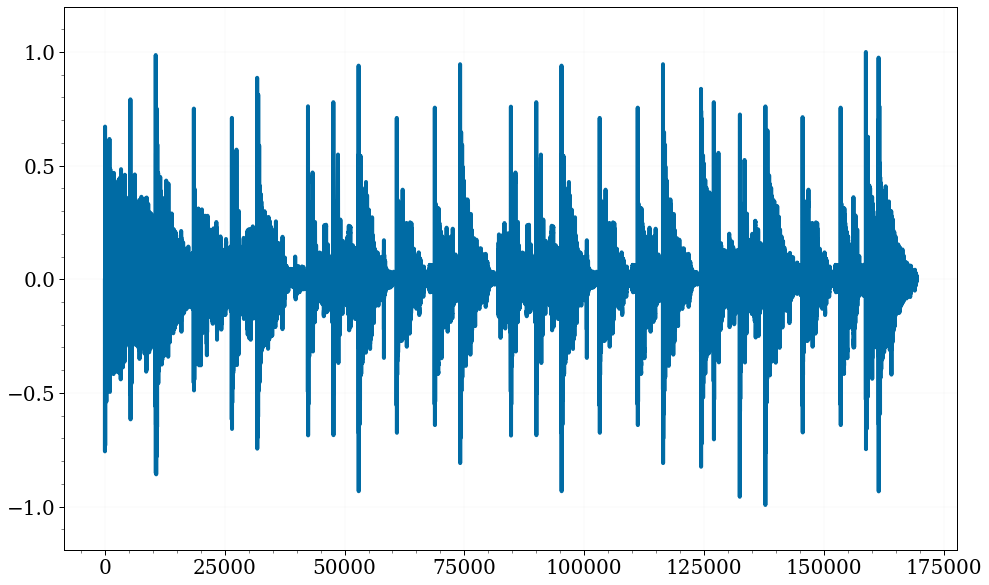

In [ ]:
plt.plot(wav)

### SVD como um problema de otimização

Agora voltando para SVD. Observe como o espectrograma é uma matriz de valores complexas

In [ ]:
S = librosa.stft(wav)
S[1, 0]

(21.010492-2.903927e-15j)

In [ ]:
S.real

array([[-2.04294434e+01, -9.60280991e+00,  8.57357323e-01, ...,
         2.86548818e-03,  2.77445111e-02,  1.50528997e-01],
       [ 2.10104923e+01, -1.22868609e+00, -5.03100574e-01, ...,
        -2.04157755e-02,  7.20952218e-03, -6.23248741e-02],
       [-2.65991325e+01,  1.11167183e+01,  2.21814632e+00, ...,
         1.98108591e-02,  2.22539827e-02, -1.32204458e-01],
       ...,
       [-1.06431765e-03,  6.45676104e-04,  5.56440573e-05, ...,
         2.59905064e-05,  3.07723647e-04, -2.18525412e-03],
       [ 9.81305144e-04, -3.17966886e-04, -2.34028790e-04, ...,
        -1.96095876e-04, -1.19744625e-04, -1.15760497e-03],
       [-6.83862483e-04,  5.79404514e-05,  3.53292795e-04, ...,
         3.19004641e-04,  5.40562265e-04,  3.09617771e-03]], dtype=float32)

In [ ]:
S.imag

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.9039271e-15,  1.0714315e+01, -2.4061909e-01, ...,
        -5.8182417e-03,  1.4468883e-02,  1.1686841e-01],
       [-4.6189223e-15,  3.4777143e+00, -4.1857952e-01, ...,
         3.1232927e-02, -3.4713306e-02, -9.1028683e-02],
       ...,
       [ 1.7803019e-16,  3.2414848e-04, -2.9644073e-04, ...,
        -1.3354661e-04, -3.1610118e-05,  2.0205786e-03],
       [ 5.1694760e-16, -6.9710822e-04,  3.7518269e-04, ...,
        -8.7013963e-05, -2.8488161e-05, -2.5324591e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Como é comum, vamos trabalhar na norma do número complexo. Assim, fazemos uso de `np.abs` para pegar tal norma. Isto é, sendo $z$ o valor complexo, $z = a + i\cdot b$, então sua norma é $|z| = \sqrt{a^2 + b^2}$.

Vamos guardar também o ângulo. Teremos um uso para o mesmo no futuro.

In [ ]:
X = np.abs(S)
A = np.angle(S)

In [ ]:
def plot_spec(X, fig=None, ax=None, color=True):
    '''Aqui X tem que ser o absoluto'''

    if fig is None and ax is None:
        fig, ax = plt.subplots()

    X_db = librosa.amplitude_to_db(X, ref=np.max)
    img = librosa.display.specshow(X_db, x_axis='time', y_axis='log', ax=ax)
    if color:
        fig.colorbar(img, ax=ax, format="%+2.f dB");

Por fim, temos o nosso espectrograma de tempo curto!

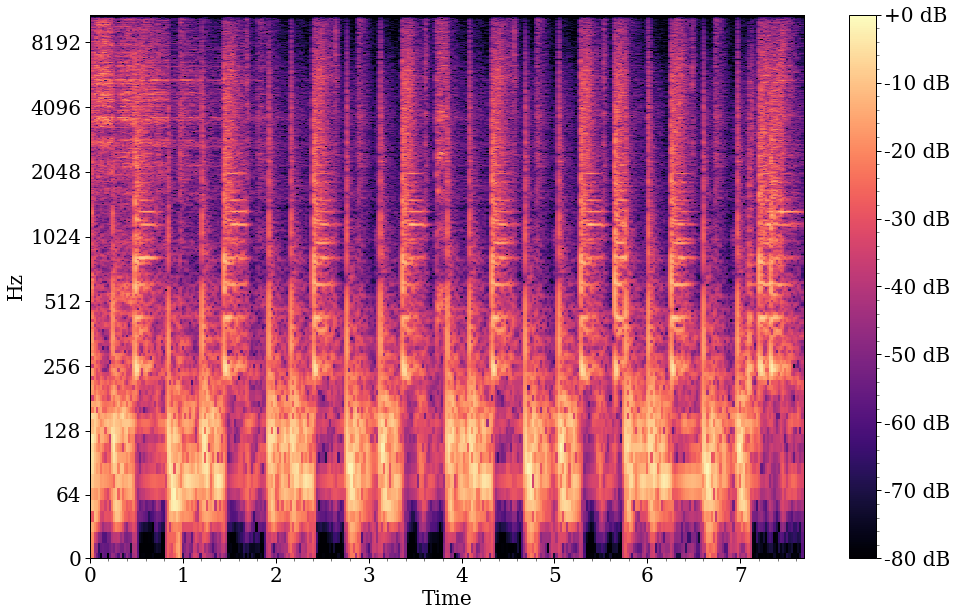

In [ ]:
plot_spec(X)


Agora vamos tentar colar as duas coisas juntas. A bateria tem uma série de informação que se repete, abaixo tentei ressaltar algumas partes.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig3.png)

Parece que algums frequências aparecem mais em alguns tempos. Primeiro temos frequências baixa, depois alta, depois baixa. Tu, pa, tu, pa.... Além disso deve ter um ts, ts, ts constante por aí. O importante é. INFORMAÇÃO REDUNDANTE. Que ferramenta bacana aprendemos para achar tal informação?


## Otimizando SVD


Observe que podemos re-escrever nossa definição de SVD da seguinte forma:

$$ U_s V^{t} - X = \mathbf{0} $$ 

Onde, $\mathbf{0}$ é uma matriz do mesmo tamanho de X, porém composta apenas de zeros. Ora, se a diferença acima é a matriz de zeros, isto quer dizer que a norma dos dois lados (isto vai valer para qualquer norma) tem que ser zero! 

$$ || U_s V^{t} - X || =  || \mathbf{0} || $$ 

Você já deve estar pensando, ok, vou otimizar alguma coisa. Portando, vamos trabalhar com normas *ponto-a-ponto*:

$$ || U_s V^{t} - X ||_{p} =  0 $$

Onde a norma é definida como:

$$|| M \|_{p} = \left( \sum_{i=1}^n \sum_{j=1}^m |a_{i,j}|^p \right)^{1/p}$$

Vamos fazer uso da norma $p=2$ e elevar ao quadrado, tudo é mais fácil ao quadrado. E no fim do dia é um pouco por isso mesmo.

$$ || U_s V^{t} - X ||^2_{2} = \sum_{i=1}^n \sum_{j=1}^m ( (U_s V^{t})_{i,j} - X_{i,j})^2 = 0 $$

Uma soma de quadrados. Que lindo. Conhecemos os dados $X$, nosso espectrograma. Desconhecemos $U_s$ e $V$. Como achar? Deriva, otimiza, seja feliz, use JAX.

In [ ]:
@jax.jit
def svd_loss(Us, Vh, X):
    X_model = Us @ Vh
    return jnp.mean((X - X_model) ** 2)

In [ ]:
grad_fn = jax.grad(svd_loss, argnums=(0, 1))

Agora vamos testar!

In [ ]:
k = 3
rows, cols = X.shape
Us = jnp.array(np.random.normal(size=(rows, k)))
Vh = jnp.array(np.random.normal(size=(k, cols)))

lr = 10
for i in range(5000):
    Us_prime, Vh_prime = grad_fn(Us, Vh, X)
    Us = Us - lr * Us_prime
    Vh = Vh - lr * Vh_prime
    if i % 100 == 0:
        print(i, svd_loss(Us, Vh, X))

0 12.749766
100 4.00207
200 2.3627582
300 2.2901294
400 2.1558614
500 2.0649617
600 2.0343106
700 2.0224447
800 2.015017
900 2.0090816
1000 2.0041087
1100 1.9999905
1200 1.9966594
1300 1.9940271
1400 1.9919883
1500 1.9904344
1600 1.9892653
1700 1.988394
1800 1.9877497
1900 1.9872751
2000 1.986928
2100 1.9866742
2200 1.986489
2300 1.9863546
2400 1.9862566
2500 1.9861857
2600 1.986134
2700 1.9860965
2800 1.9860692
2900 1.9860497
3000 1.9860353
3100 1.986025
3200 1.9860177
3300 1.9860121
3400 1.986008
3500 1.9860053
3600 1.9860033
3700 1.9860018
3800 1.9860005
3900 1.986
4000 1.9859992
4100 1.9859989
4200 1.9859985
4300 1.9859985
4400 1.9859982
4500 1.9859982
4600 1.9859982
4700 1.9859979
4800 1.9859979
4900 1.9859979


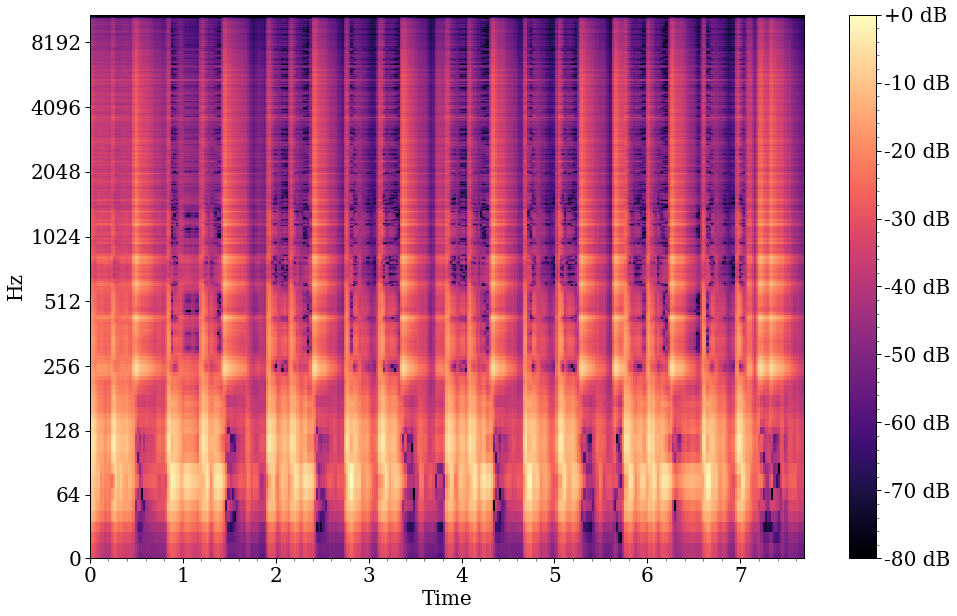

In [ ]:
# Observe como funciona bem
plot_spec(Us @ Vh)

Abaixo tenho uma função que plota a parte recuperada por cada "produto externo". Ou seja, olho apenas para uma linha/coluna de Us e Vt.


In [ ]:
def recover_from_one(Us, Vh, factor):
    right = Us[:, factor][:, np.newaxis]
    left = Vh[factor][np.newaxis]
    return right.dot(left)

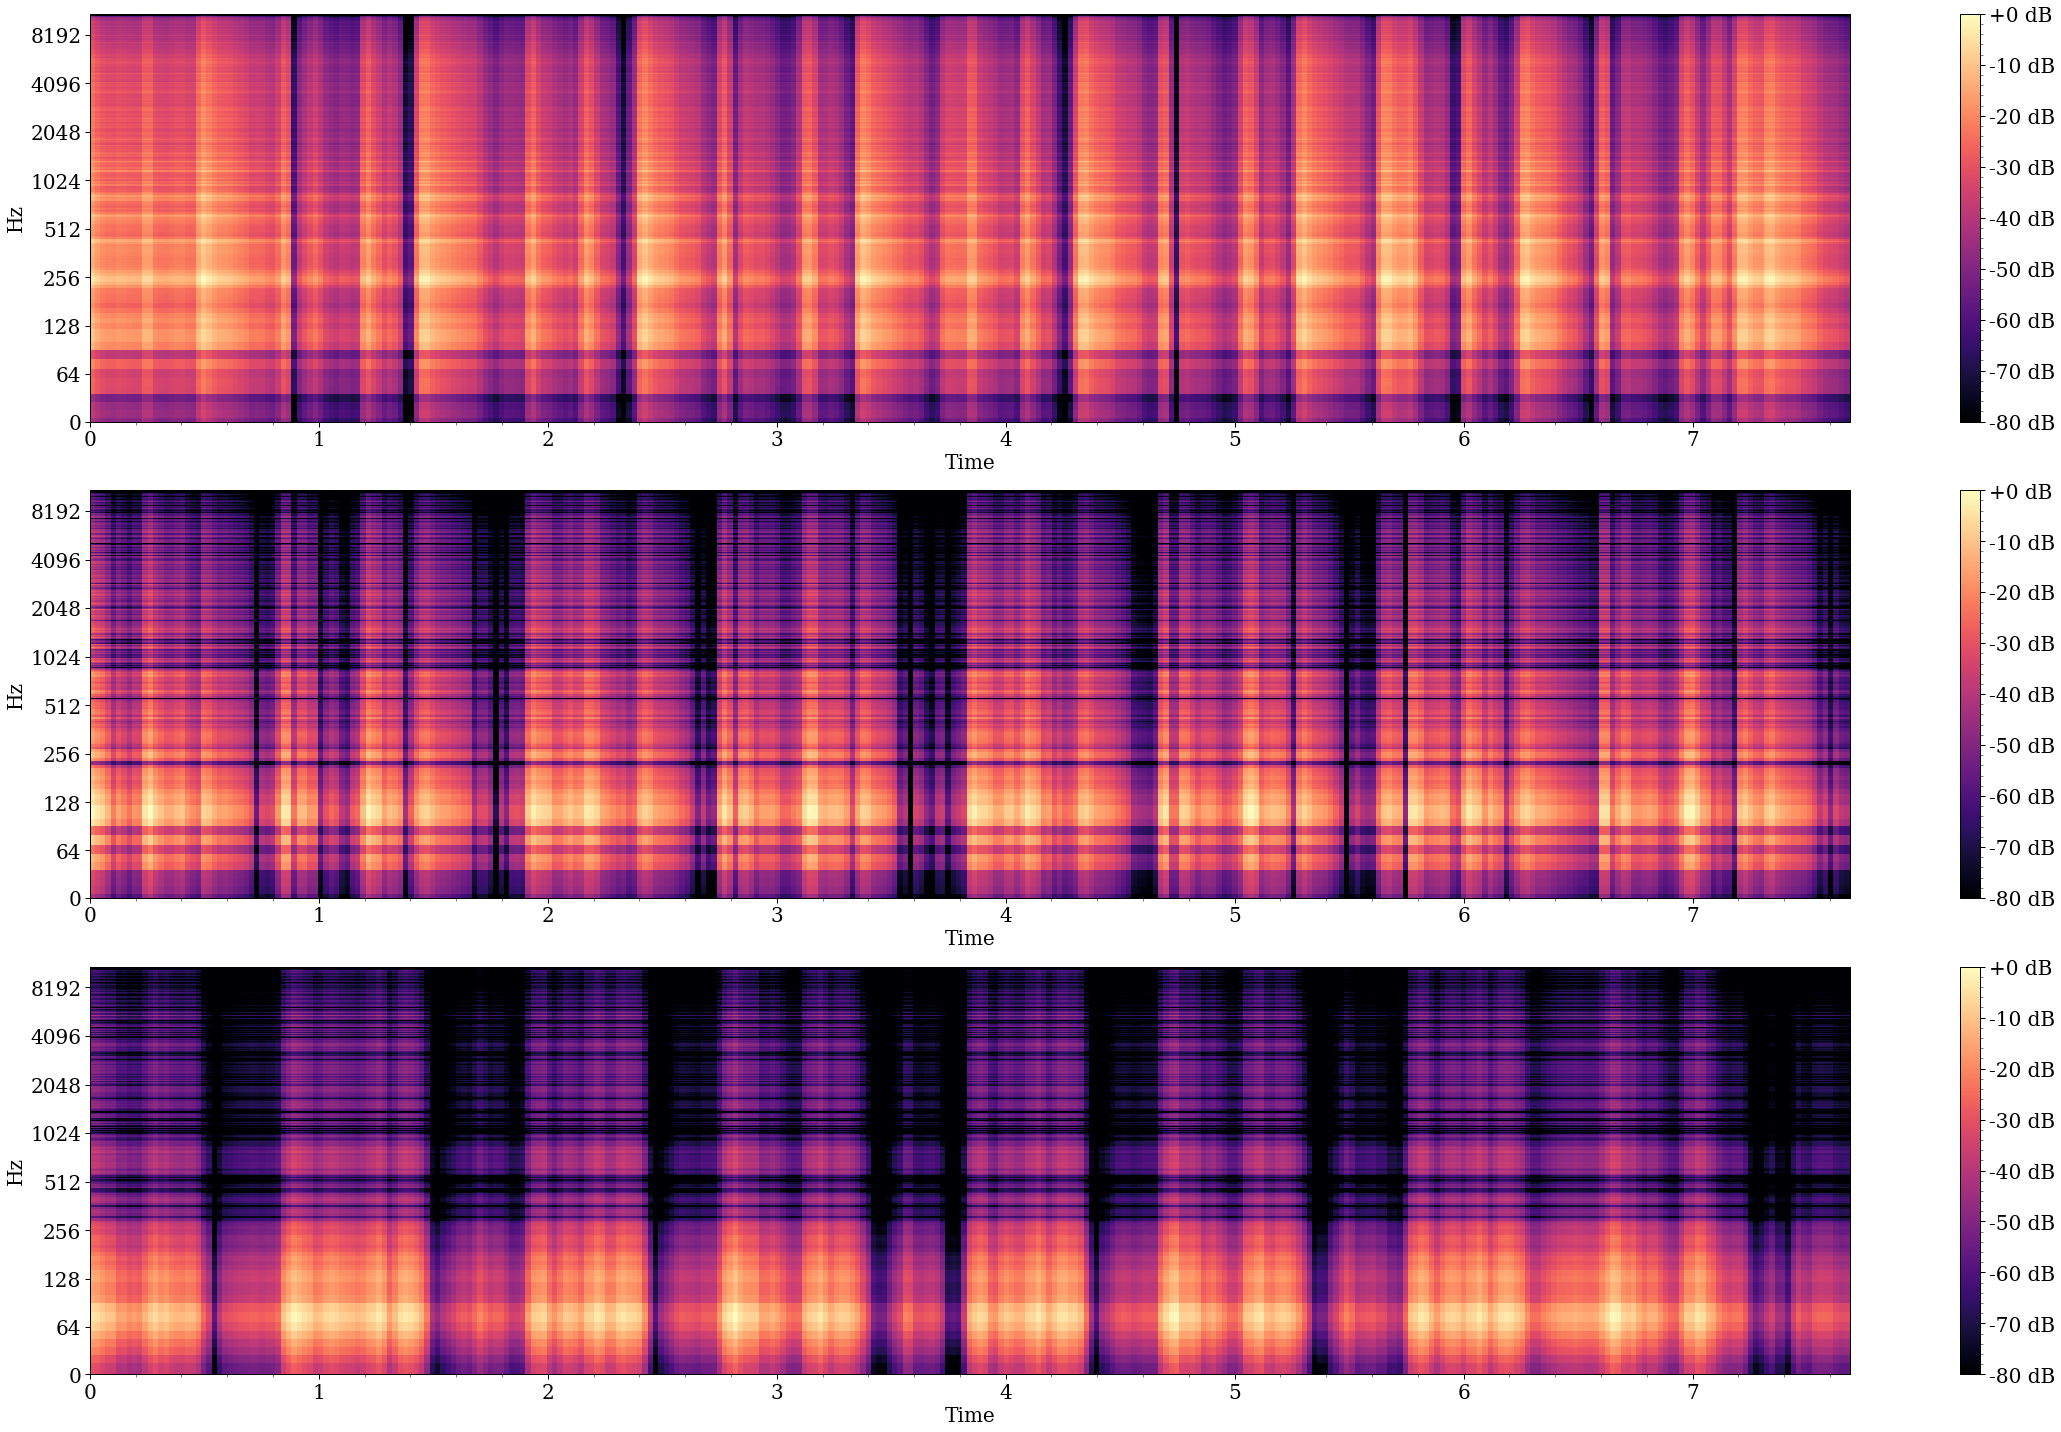

In [ ]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

Codificando tudo em uma função para uso futuro!

In [ ]:
def svd(X, k, lr=10, max_iter=5000, verbose=True, Us=None, Vh=None):
    
    # Caso não passe k, as matrizes foram iniciadas por fora
    if k is None:
        assert(Us is not None or Vh is not None)
    
    # Caso Us não foi iniciada
    if Us is None:
        if k is None: # Vh foi iniciada ?
            assert(Vh is not None)
            k = Vh.shape[0]
        Us = jnp.array(np.random.normal(size=(rows, k)))

    # Aqui com certeza Us foi inicializada (na função ou fora)
    # Inice Vh caso não tenha sido por fora
    if Vh is None:
        k = Us.shape[1]
        Vh = jnp.array(np.random.normal(size=(k, cols))) 

    # Verifique os tamanhos
    assert(Us.shape[1] == Vh.shape[0])
    assert(Us.shape[1] <= X.shape[1])
    
    # Finalmente, SVD
    X = jnp.asarray(X)
    Us = jnp.asarray(Us)
    Vh = jnp.asarray(Vh)

    @jax.jit
    def svd_loss(Us, Vh, X):
        X_model = Us @ Vh
        return jnp.mean((X - X_model) ** 2)
    grad_fn = jax.grad(svd_loss, argnums=(0, 1))

    for i in range(max_iter):
        Us_prime, Vh_prime = grad_fn(Us, Vh, X)
        Us = Us - lr * Us_prime
        Vh = Vh - lr * Vh_prime
        if i % 100 == 0 and verbose:
            print(i, svd_loss(Us, Vh, X))
    return Us, Vh

0 12.593563
100 3.6157146
200 2.3598373
300 2.2949314
400 2.1586275
500 2.0461686
600 2.0059628
700 1.9950048
800 1.9914714
900 1.9898347
1000 1.9888251
1100 1.9881147
1200 1.9875904
1300 1.9871978
1400 1.9869019
1500 1.9866788
1600 1.9865106
1700 1.9863837
1800 1.9862881
1900 1.9862162
2000 1.9861621
2100 1.9861212
2200 1.9860908
2300 1.9860678
2400 1.9860505
2500 1.9860371
2600 1.9860274
2700 1.9860201
2800 1.9860145
2900 1.9860104
3000 1.9860073
3100 1.9860051
3200 1.986003
3300 1.9860018
3400 1.9860007
3500 1.986
3600 1.9859995
3700 1.9859992
3800 1.9859989
3900 1.9859985
4000 1.9859983
4100 1.9859982
4200 1.9859982
4300 1.9859982
4400 1.9859978
4500 1.9859979
4600 1.9859979
4700 1.9859979
4800 1.9859978
4900 1.9859978


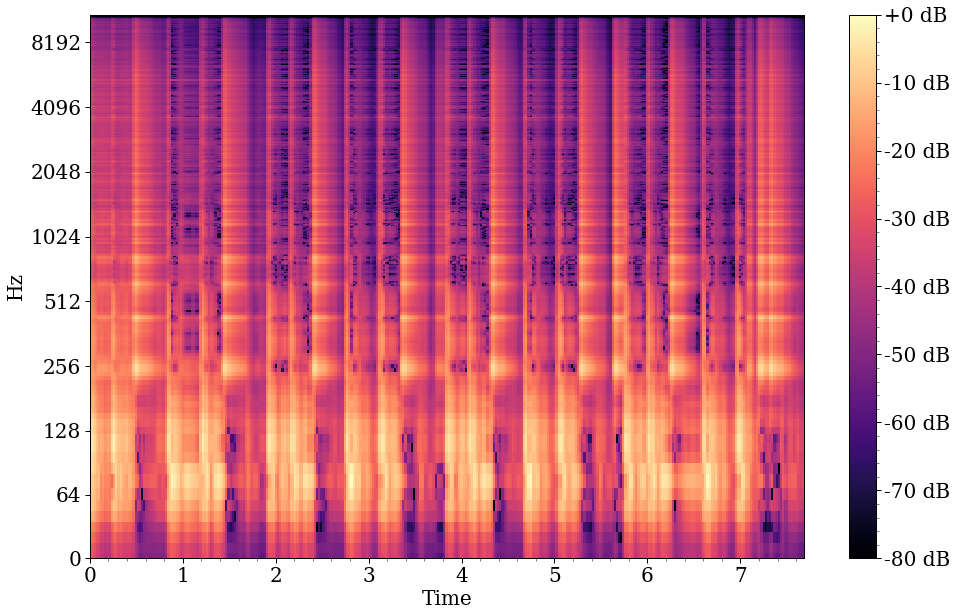

In [ ]:
Us, Vh = svd(X, 3, verbose=True)
plot_spec(Us @ Vh)

## Voltando para a música original

Infelizmente nosso espectrograma tem fatores complexos. Nosso SVD não fez uso de tais fatores na sua otimização. Até que seria possível com JAX, mas preferi não fazer. Portanto, vou voltar o espectrograma para complexo usando o ângulo que guardamos antes. Escute cada trecho que é recuperado por cada fator do nosso SVD. *Fez sentido?*

In [ ]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

## Decomposição Não Negativa

Um dos problemas de SVD é que os valores recuperados podem ser negativos. Por exemplo, observe o primeiro fator abaixo:

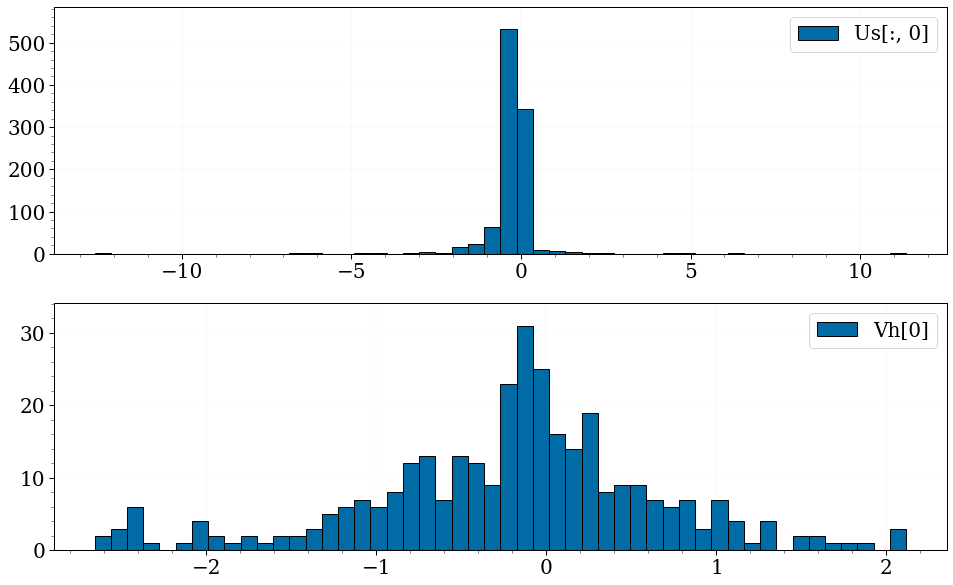

In [ ]:
fig, axes = plt.subplots(2, 1)

axes[0].hist(Us[:, 0].ravel(), bins=50, edgecolor='k', label='Us[:, 0]')
axes[0].legend()

axes[1].hist(Vh[0].ravel(), bins=50, edgecolor='k', label='Vh[0]')
axes[1].legend()

Como temos números negativos, é complicado interpretar algum tipo de presença ou ausência de sinal. Isto vem do fato de que ao recuperar X com este fator teremos:

\begin{align}
    X &= \begin{bmatrix}
           c_{1, 1} \\
           c_{2, 1} \\
           \vdots \\
           c_{n, 1}
         \end{bmatrix}\begin{bmatrix}
           l_{1, 1}, 
           l_{1, 2}, 
           \cdots,
           l_{1, m}
         \end{bmatrix}
  \end{align}

Na expressão acima, podemos ter multiplicações de positivos com positivos, positivos com negativos (e vice-versa), ou negativos com negativos. Como X é toda positiva, seria melhor que os nossos fatores também fosse. Assim pelo menos podemos interpretar que quanto maior o valor, maior o sinal.

Existe uma "variação de SVD" (dizer que é variação é mentira, mas ok) onde podemos forçar que tudo seja positivo. A mesma está implementada abaixo.

In [ ]:
def nmf(X, k, max_iter=5000, verbose=True, Us=None, Vh=None):
    
    # Caso não passe k, as matrizes foram iniciadas por fora
    if k is None:
        assert(Us is not None or Vh is not None)
    
    # Caso Us não foi iniciada
    if Us is None:
        if k is None: # Vh foi iniciada ?
            assert(Vh is not None)
            k = Vh.shape[0]
        Us = jnp.array(np.random.uniform(size=(rows, k)))

    # Aqui com certeza Us foi inicializada (na função ou fora)
    # Inice Vh caso não tenha sido por fora
    if Vh is None:
        k = Us.shape[1]
        Vh = jnp.array(np.random.uniform(size=(k, cols))) 

    # Verifique os tamanhos
    assert(Us.shape[1] == Vh.shape[0])
    assert(Us.shape[1] <= X.shape[1])

    # Finalmente, NMF
    X = jnp.asarray(X)
    Us = jnp.asarray(Us)
    Vh = jnp.asarray(Vh)

    for i in range(max_iter):
        Us = Us * ((X @ Vh.T) / (((Us @ Vh) @ Vh.T) + 0.0001))
        Vh = Vh * ((Us.T @ X) / (((Us.T @ Us) @ Vh) + 0.0001))
        if i % 100 == 0 and verbose:
            X_model = Us @ Vh
            print(i, jnp.mean((X - X_model) ** 2))
    return Us, Vh

Us, Vh = nmf(X, 3)

0 4.792943
100 1.9914204
200 1.9910553
300 1.9910246
400 1.9910171
500 1.9910147
600 1.9910134
700 1.9910123
800 1.9910111
900 1.991011
1000 1.9910104
1100 1.9910103
1200 1.9910103
1300 1.9910103
1400 1.9910101
1500 1.99101
1600 1.9910101
1700 1.99101
1800 1.99101
1900 1.99101
2000 1.99101
2100 1.99101
2200 1.99101
2300 1.9910097
2400 1.99101
2500 1.99101
2600 1.99101
2700 1.99101
2800 1.99101
2900 1.99101
3000 1.99101
3100 1.99101
3200 1.99101
3300 1.99101
3400 1.99101
3500 1.99101
3600 1.99101
3700 1.99101
3800 1.99101
3900 1.99101
4000 1.99101
4100 1.99101
4200 1.99101
4300 1.99101
4400 1.99101
4500 1.99101
4600 1.99101
4700 1.99101
4800 1.99101
4900 1.99101


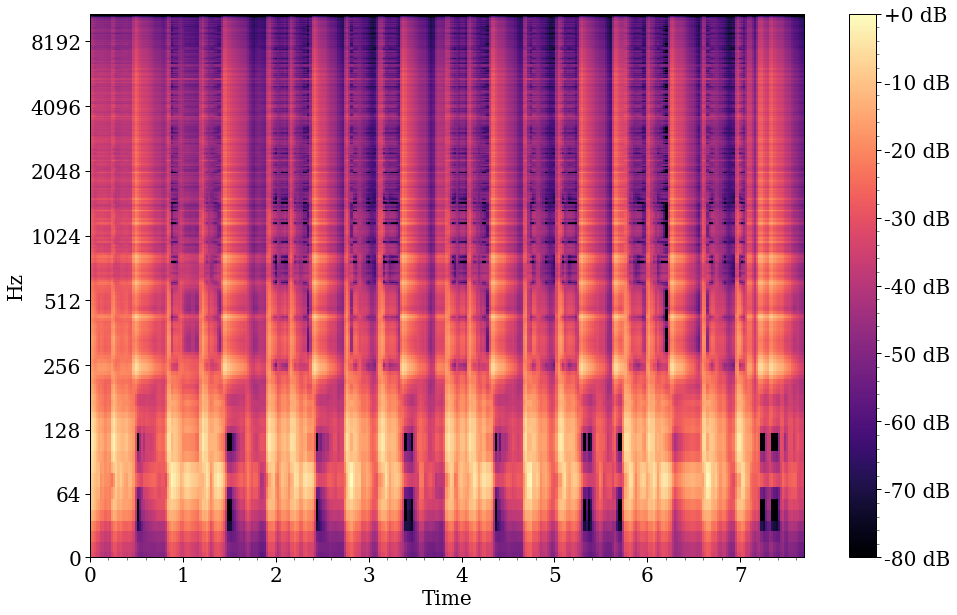

In [ ]:
plot_spec(Us @ Vh)

Observe que agora tudo é não negativo

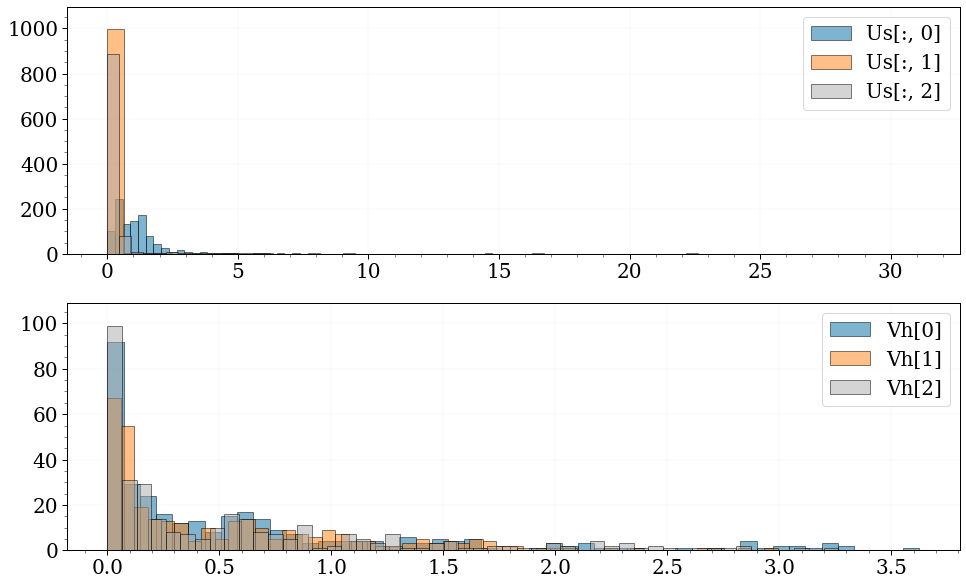

In [ ]:
fig, axes = plt.subplots(2, 1)

for i in range(k):
    axes[0].hist(Us[:, i].ravel(), bins=50, edgecolor='k', label=f'Us[:, {i}]',
                 alpha=0.5)
    axes[1].hist(Vh[i].ravel(), bins=50, edgecolor='k', label=f'Vh[{i}]',
                 alpha=0.5)
axes[0].legend()
axes[1].legend()

Observe como os fatores mudam, ficam mais esparsos. Agora, podemos recuperar como antes. *Melhorou?*

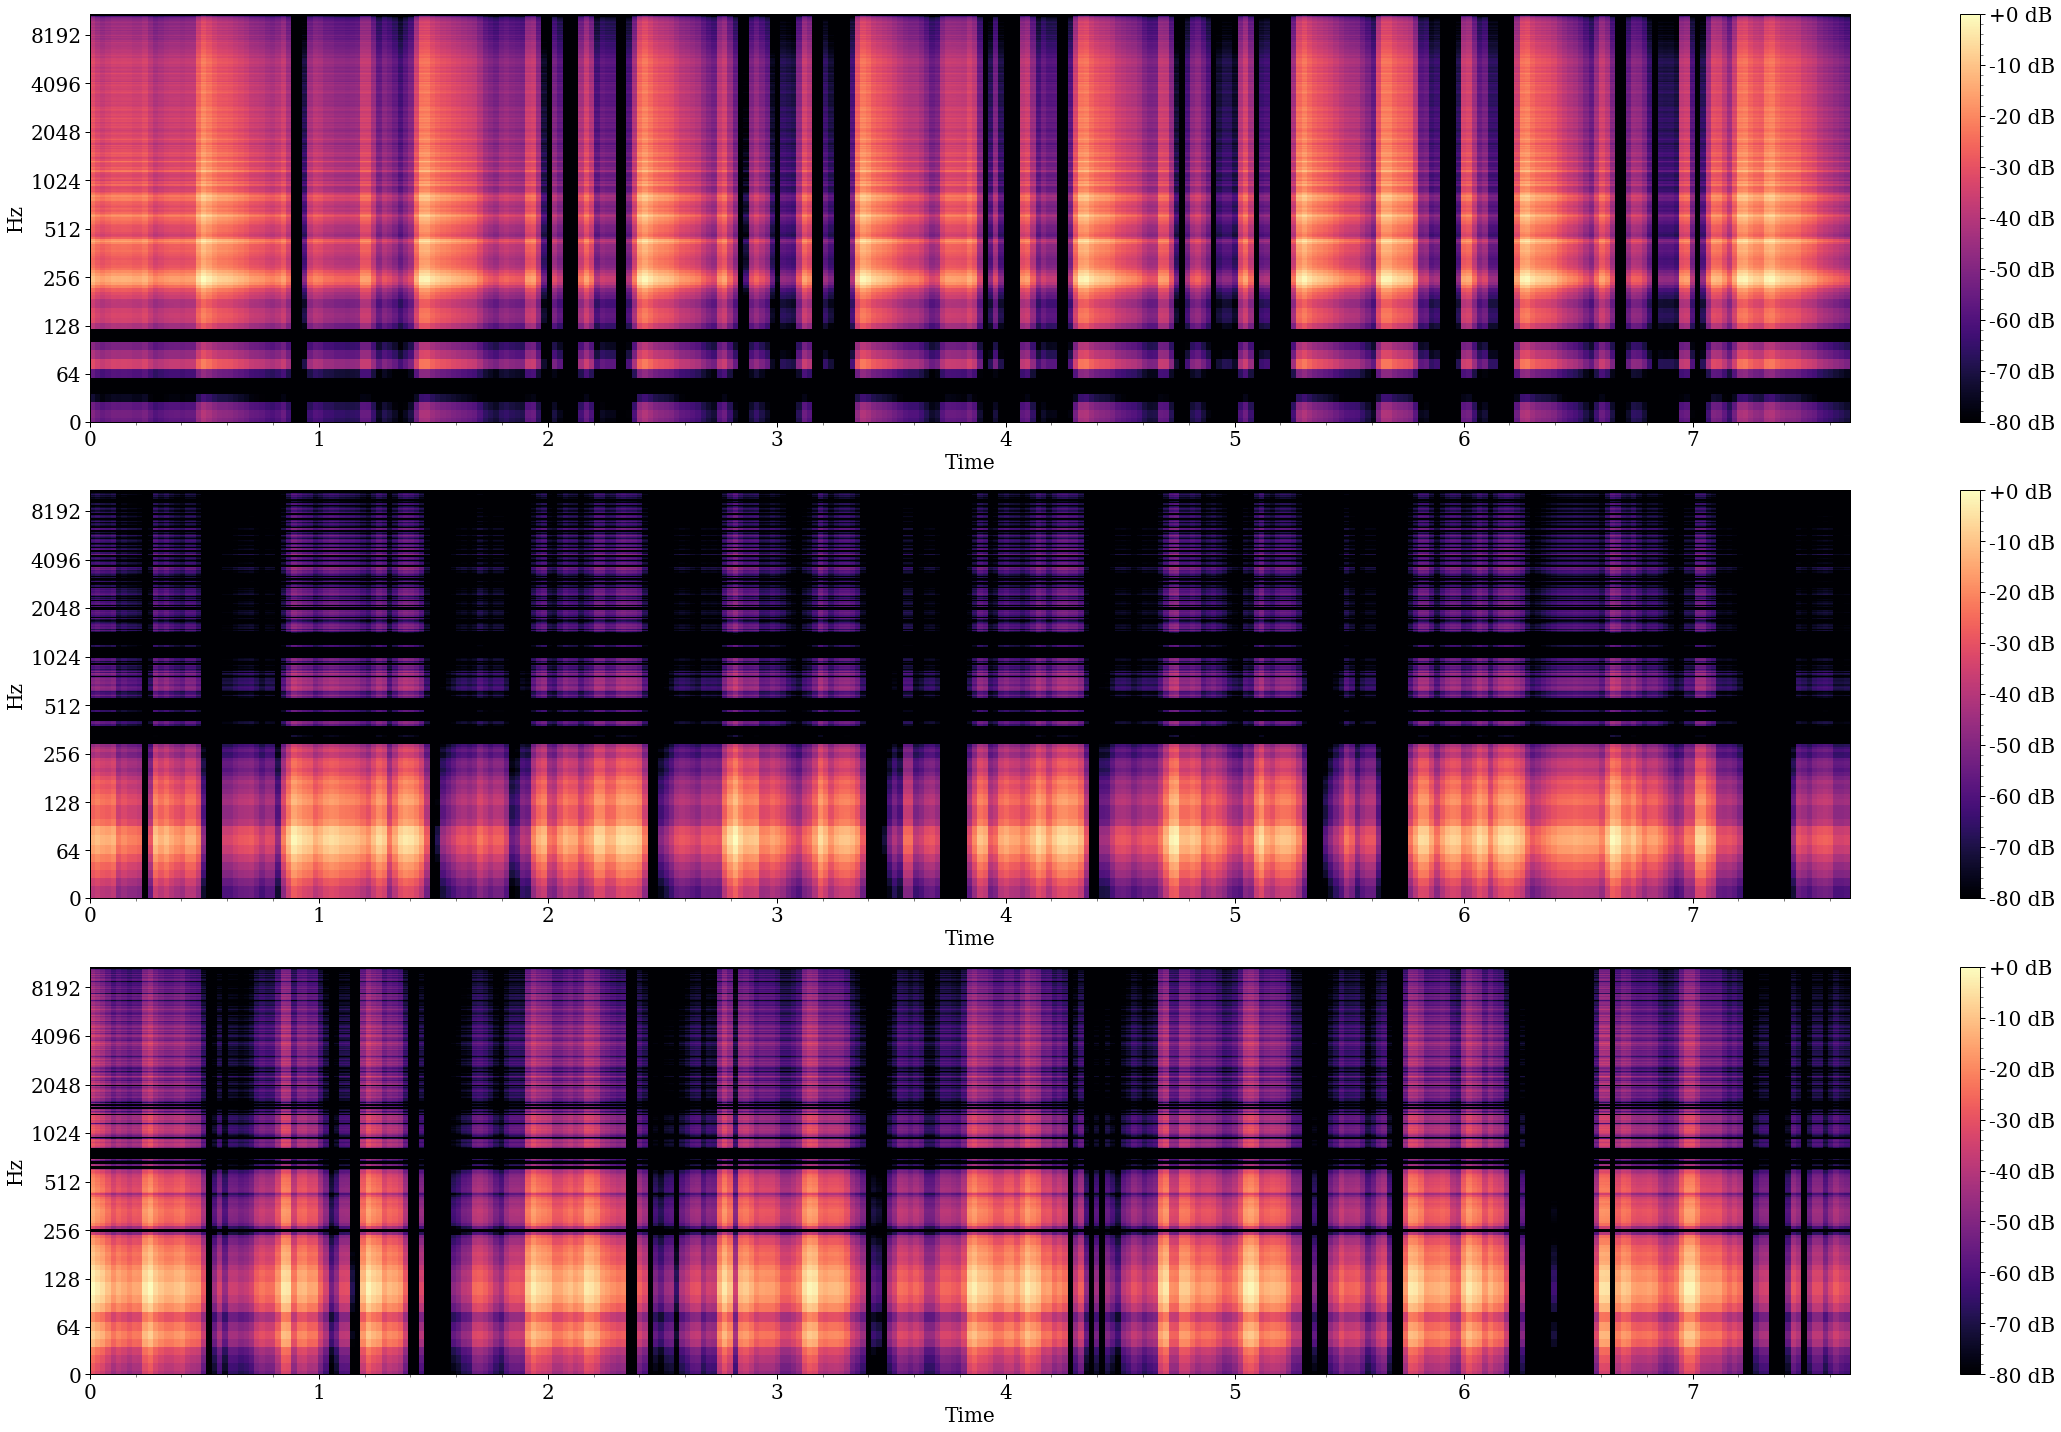

In [ ]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [ ]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

## Sua Tarefa (Finalmente)

Usando a base anotada de toques de bateria do IDMT (já baixada, mas caso queira a original [venha aqui](https://www.idmt.fraunhofer.de/en/publications/datasets/drums.html)), sua tarefa será em decompor pequenas faixas de bateria. A base já foi baixada neste notebook. Os WAVs da mesma estão em ```audio/```.

In [ ]:
! ls audio

RealDrum01_00#HH#train.wav    WaveDrum02_21#HH#train.wav
RealDrum01_00#KD#train.wav    WaveDrum02_21#HH.wav
RealDrum01_00#MIX.wav	      WaveDrum02_21#KD#train.wav
RealDrum01_00#SD#train.wav    WaveDrum02_21#KD.wav
RealDrum01_01#HH#train.wav    WaveDrum02_21#MIX.wav
RealDrum01_01#KD#train.wav    WaveDrum02_21#SD#train.wav
RealDrum01_01#MIX.wav	      WaveDrum02_21#SD.wav
RealDrum01_01#SD#train.wav    WaveDrum02_22#HH#train.wav
RealDrum01_02#HH#train.wav    WaveDrum02_22#HH.wav
RealDrum01_02#KD#train.wav    WaveDrum02_22#KD#train.wav
RealDrum01_02#MIX.wav	      WaveDrum02_22#KD.wav
RealDrum01_02#SD#train.wav    WaveDrum02_22#MIX.wav
RealDrum01_03#HH#train.wav    WaveDrum02_22#SD#train.wav
RealDrum01_03#KD#train.wav    WaveDrum02_22#SD.wav
RealDrum01_03#MIX.wav	      WaveDrum02_23#HH#train.wav
RealDrum01_03#SD#train.wav    WaveDrum02_23#HH.wav
RealDrum01_04#HH#train.wav    WaveDrum02_23#KD#train.wav
RealDrum01_04#KD#train.wav    WaveDrum02_23#KD.wav
RealDrum01_04#MIX.wav	      WaveDrum02_2

Para carregar todos use glob. Sua tarefa será fazer uso dos arquivos MIX, que já misturam todas os tambores. Observe que temos diferentes tipos de baterias. TechnoDrums, WaveDrums (eletrônicas) e RealDrums.

In [ ]:
import glob

files = glob.glob('audio/*MIX*.wav')
files

['audio/WaveDrum02_21#MIX.wav',
 'audio/WaveDrum02_23#MIX.wav',
 'audio/WaveDrum02_07#MIX.wav',
 'audio/WaveDrum02_20#MIX.wav',
 'audio/WaveDrum02_39#MIX.wav',
 'audio/WaveDrum02_42#MIX.wav',
 'audio/WaveDrum02_43#MIX.wav',
 'audio/RealDrum01_01#MIX.wav',
 'audio/WaveDrum01_03#MIX.wav',
 'audio/WaveDrum02_14#MIX.wav',
 'audio/WaveDrum01_08#MIX.wav',
 'audio/TechnoDrum01_04#MIX.wav',
 'audio/WaveDrum02_60#MIX.wav',
 'audio/WaveDrum02_31#MIX.wav',
 'audio/WaveDrum01_07#MIX.wav',
 'audio/WaveDrum01_02#MIX.wav',
 'audio/TechnoDrum01_07#MIX.wav',
 'audio/RealDrum01_12#MIX.wav',
 'audio/RealDrum01_11#MIX.wav',
 'audio/TechnoDrum01_08#MIX.wav',
 'audio/WaveDrum02_05#MIX.wav',
 'audio/WaveDrum02_45#MIX.wav',
 'audio/WaveDrum02_02#MIX.wav',
 'audio/RealDrum01_06#MIX.wav',
 'audio/WaveDrum02_26#MIX.wav',
 'audio/WaveDrum01_09#MIX.wav',
 'audio/RealDrum01_04#MIX.wav',
 'audio/WaveDrum02_25#MIX.wav',
 'audio/TechnoDrum01_02#MIX.wav',
 'audio/TechnoDrum01_06#MIX.wav',
 'audio/RealDrum01_08#MIX.wav'

In [ ]:
wav, sr = librosa.load(files[1])
ipd.Audio(wav, rate=sr)

In [ ]:
! ls annotation_xml

RealDrum01_00#MIX.xml	 WaveDrum01_07#MIX.xml	WaveDrum02_30#MIX.xml
RealDrum01_01#MIX.xml	 WaveDrum01_08#MIX.xml	WaveDrum02_31#MIX.xml
RealDrum01_02#MIX.xml	 WaveDrum01_09#MIX.xml	WaveDrum02_32#MIX.xml
RealDrum01_03#MIX.xml	 WaveDrum02_01#MIX.xml	WaveDrum02_33#MIX.xml
RealDrum01_04#MIX.xml	 WaveDrum02_02#MIX.xml	WaveDrum02_34#MIX.xml
RealDrum01_05#MIX.xml	 WaveDrum02_03#MIX.xml	WaveDrum02_35#MIX.xml
RealDrum01_06#MIX.xml	 WaveDrum02_04#MIX.xml	WaveDrum02_36#MIX.xml
RealDrum01_07#MIX.xml	 WaveDrum02_05#MIX.xml	WaveDrum02_37#MIX.xml
RealDrum01_08#MIX.xml	 WaveDrum02_06#MIX.xml	WaveDrum02_38#MIX.xml
RealDrum01_09#MIX.xml	 WaveDrum02_07#MIX.xml	WaveDrum02_39#MIX.xml
RealDrum01_10#MIX.xml	 WaveDrum02_08#MIX.xml	WaveDrum02_40#MIX.xml
RealDrum01_11#MIX.xml	 WaveDrum02_09#MIX.xml	WaveDrum02_41#MIX.xml
RealDrum01_12#MIX.xml	 WaveDrum02_10#MIX.xml	WaveDrum02_42#MIX.xml
RealDrum01_13#MIX.xml	 WaveDrum02_11#MIX.xml	WaveDrum02_43#MIX.xml
TechnoDrum01_00#MIX.xml  WaveDrum02_12#MIX.xml	WaveDrum02_44#M

Por motivos que eu nunca vou entender, os autores fizeram uso de XML para as anotações. Abaixo segue um exemplo de arquivo.

In [ ]:
! cat annotation_xml/RealDrum01_00#MIX.xml

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<instrumentRecording>
  <globalParameter>
    <audioFileName>RealDrum01_00#MIX.wav</audioFileName>
    <recordingArtist>Feliks Weber</recordingArtist>
    <mixGroundTrouthAvailable>false</mixGroundTrouthAvailable>
    <mixGroundTrouthHasInterference>true</mixGroundTrouthHasInterference>
    <audioTrainingFileName>RealDrum01_00#HH#train.wav</audioTrainingFileName>
    <audioTrainingFileName>RealDrum01_00#KD#train.wav</audioTrainingFileName>
    <audioTrainingFileName>RealDrum01_00#SD#train.wav</audioTrainingFileName>
  </globalParameter>
  <transcription>
    <event>
      <pitch>0</pitch>
      <onsetSec>0.08585</onsetSec>
      <offsetSec>0.08585</offsetSec>
      <instrument>HH</instrument>
    </event>
    <event>
      <pitch>0</pitch>
      <onsetSec>0.091791</onsetSec>
      <offsetSec>0.091791</offsetSec>
      <instrument>KD</instrument>
    </event>
    <event>
      <pitch>0</pitch>
      <onsetSec>0.50431</onsetSec>
   

Com BeautifulSoup você consegue extrair os tempos e nomes dos instrumentos.

In [ ]:
from bs4 import BeautifulSoup
with open('annotation_xml/RealDrum01_00#MIX.xml') as f:
    events = BeautifulSoup(f).findAll('event')
    times = []
    names = []
    for event in events:
        times.append(float(event.find('onsetsec').text))
        names.append(event.find('instrument').text)

**Sua Tarefa na Prática**

A figura abaixo mostra um exemplo do Librosa extraindo **curvas** de batidas com dois métodos diferentes. Em particular estamos comparando o [Onset Strength](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html) e o [Predominant Local Pulse](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S3_PredominantLocalPulse.html).

![](https://librosa.org/doc/latest/_images/librosa-beat-plp-1_01.png)

Além do mais, com o nosso conhecimento de SVD e NMF sabemos decompor músicas. Vamos combinar os dois.


1. Você deve iniciar a matriz Us com frequências comuns em uma bateria. Caso queira, use os quatro quartis dos arquivos de cada tambor isolado (veja os WAVS).
1. Você deve iniciar a matriz Vt com os tempos de batidas.
1. Avalie se funcione, altera o número de fatores latentes extraídos por SVD/NMF.
1. Mensure a Precisão e Revocação!
1. Compare com inicializações aleatórias.


![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig4.png)

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig5.png)

**Sua Solução**